# Out-of-Domain Generalization: Hate Speech Detection

This notebook evaluates how well domain-specific classifiers generalize to out-of-domain hate speech detection.
We test various model architectures trained on domain classification to see if they can effectively identify hate speech.

Key aspects evaluated:
- Few-shot transfer capabilities using DSPy
- Model robustness across different datasets

## Model Overview

This notebook evaluates several classification models:
1. **LLM-based**: Using Qwen 2.5 for zero-shot classification
2. **BERT-based**: ModernBERT with NLI approach
3. **Traditional ML**: 
   - fastText for efficient text classification
   - SVM and XGBoost with different embeddings

Each model is evaluated on hate speech detection as an out-of-domain task.

## Setup
Import dependencies and initialize models

In [1]:
import os
import pickle as pkl
import random
import statistics
import time
from functools import partial

import fasttext
import numpy as np
import onnxruntime as ort
import pandas as pd
from dotenv import load_dotenv
from fastembed import TextEmbedding
from tqdm import tqdm
from transformers import AutoTokenizer
from xgboost import XGBClassifier

from prompt_classifier.metrics import evaluate_run
from prompt_classifier.modeling.dspy_llm import LlmClassifier
from prompt_classifier.modeling.fasttext import FastTextClassifier
from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI

load_dotenv()
random.seed(22)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Load Test Datasets

Load various hate speech datasets for evaluation:
- Jigsaw Toxicity
- OLID
- HateXplain
- TUKE Slovak

In [2]:
# Load Jigsaw dataset
jigsaw_splits = {
    "train": "train_dataset.csv",
    "validation": "val_dataset.csv",
    "test": "test_dataset.csv",
}
jigsaw_df = pd.read_csv(
    "hf://datasets/Arsive/toxicity_classification_jigsaw/" + jigsaw_splits["validation"]
)

jigsaw_df = jigsaw_df[
    (jigsaw_df["toxic"] == 1)
    | (jigsaw_df["severe_toxic"] == 1)
    | (jigsaw_df["obscene"] == 1)
    | (jigsaw_df["threat"] == 1)
    | (jigsaw_df["insult"] == 1)
    | (jigsaw_df["identity_hate"] == 1)
]

jigsaw_df = jigsaw_df.rename(columns={"comment_text": "prompt"})
jigsaw_df["label"] = 0
jigsaw_df = jigsaw_df[["prompt", "label"]]
jigsaw_df = jigsaw_df.dropna(subset=["prompt"])
jigsaw_df = jigsaw_df[jigsaw_df["prompt"].str.strip() != ""]

# Load OLID dataset
olid_splits = {"train": "train.csv", "test": "test.csv"}
olid_df = pd.read_csv("hf://datasets/christophsonntag/OLID/" + olid_splits["train"])
olid_df = olid_df.rename(columns={"cleaned_tweet": "prompt"})
olid_df["label"] = 0
olid_df = olid_df[["prompt", "label"]]
olid_df = olid_df.dropna(subset=["prompt"])
olid_df = olid_df[olid_df["prompt"].str.strip() != ""]

# Load hateXplain dataset
hateXplain = pd.read_parquet(
    "hf://datasets/nirmalendu01/hateXplain_filtered/data/train-00000-of-00001.parquet"
)
hateXplain = hateXplain.rename(columns={"test_case": "prompt"})
hateXplain = hateXplain[(hateXplain["gold_label"] == "hateful")]
hateXplain = hateXplain[["prompt", "label"]]
hateXplain["label"] = 0
hateXplain = hateXplain.dropna(subset=["prompt"])
hateXplain = hateXplain[hateXplain["prompt"].str.strip() != ""]

# Load TUKE Slovak dataset
tuke_sk_splits = {"train": "train.json", "test": "test.json"}
tuke_sk_df = pd.read_json(
    "hf://datasets/TUKE-KEMT/hate_speech_slovak/" + tuke_sk_splits["train"], lines=True
)
tuke_sk_df = tuke_sk_df.rename(columns={"text": "prompt"})
tuke_sk_df = tuke_sk_df[tuke_sk_df["label"] == 0]
tuke_sk_df = tuke_sk_df[["prompt", "label"]]
tuke_sk_df = tuke_sk_df.dropna(subset=["prompt"])
tuke_sk_df = tuke_sk_df[tuke_sk_df["prompt"].str.strip() != ""]

# Load DKK dataset
dkk = pd.read_parquet("data/test-00000-of-00001.parquet")
dkk = dkk.rename(columns={"text": "prompt"})
dkk = dkk[dkk["label"] == "OFF"].reset_index(drop=True)
dkk["label"] = 0
dkk = dkk.dropna(subset=["prompt"])
dkk = dkk[dkk["prompt"].str.strip() != ""]

dkk_all = pd.read_parquet("data/test-00000-of-00001.parquet")
dkk_all = dkk_all.rename(columns={"text": "prompt"})
dkk_all["label"] = 0
dkk_all = dkk_all.dropna(subset=["prompt"])
dkk_all = dkk_all[dkk_all["prompt"].str.strip() != ""]

datasets = {
    "jigsaw": jigsaw_df,
    "olid": olid_df,
    "hate_xplain": hateXplain,
    "tuke_sk": tuke_sk_df,
    "dkk": dkk,
    "dkk_all": dkk_all,
}

In [3]:
display(jigsaw_df.head())
display(olid_df.head())
display(hateXplain.head())
display(tuke_sk_df.head())
display(dkk.head())
display(dkk_all.head())

,prompt,label
0,"....\n\n.... Edgar, it's Saturday night! Why ...",0
2,You are a TWAT \n\nTWAT'TWAT'TWAT'TWAT'TWAT'TW...,0
3,"Whatt a jew\nMake real articles, not stupid sp...",0
6,You don't even clean your ass when you poop. N...,0
8,You Stupid Piece Of Shit,0


,prompt,label
0,ask native americans take,0
1,go home drunk maga trump 2020,0
2,amazon investigating chinese employees selling...,0
3,someone vetaken piece shit volcano,0
4,obama wanted liberals illegals move red states,0


,prompt,label
0,<user> i am bit confused coz chinese ppl can n...,0
1,this bitch in whataburger eating a burger with...,0
2,laura loomer raped me while screaming at me in...,0
3,and this is why i end up with nigger trainee d...,0
4,guilty until proven innocent unless you are a ...,0


,prompt,label
1,user19773 tak ja uz na dovolenke a kaudy den o...,0
2,user8371 ak by vám to neprechádzalo tu mate,0
3,"user13335 nezaslúžia, ale o tom nie je reč. di...",0
5,ked sa pyta ciganikova na vzdelanie,0
6,user36201 uvidis,0


,prompt,label
0,NED MED SVENSKEN!,0
1,@USER ryger du hash. ???,0
2,DANSKJÄVLAR,0
3,hvorfor i den fucking store helvede skal man f...,0
4,De små får fri på vores skole fordi en knægt b...,0


,prompt,label
0,"Der er syriske ""flygtninge"" som rejser til Ira...",0
1,Danmark = Vitryssland?,0
2,Ja tvangsfjernelser af børn på urigtige oplysn...,0
3,Han kan ikke Svensk og forventer et job. Hvis ...,0
4,NED MED SVENSKEN!,0


## Datasets Overview

We use four major hate speech datasets:

1. **Jigsaw Toxicity**
   - Multi-label toxicity classification
   - Includes toxic, severe_toxic, obscene, threat, insult, identity_hate labels

2. **OLID (Offensive Language Identification Dataset)**
   - Hierarchical labeling of offensive language
   - Focuses on Twitter content

3. **HateXplain**
   - Annotated with rationales for hate speech
   - Includes target community information

4. **TUKE Slovak**
   - Slovak language hate speech dataset
   - Tests cross-lingual generalization

## Embedding Models

Using multiple embedding approaches:
- **BAAI BGE**: Optimized for semantic similarity
- **MiniLM**: Efficient sentence transformers model
- **TF-IDF**: Traditional bag-of-words approach

These embeddings are used with SVM and XGBoost classifiers.

In [ ]:
current_folder = os.getcwd()
print(current_folder)

In [ ]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"]
)

mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

# TF-IDF
tfidf_finance = pkl.load(open("models/tfidf_finance.pkl", "rb"))
tfidf_healthcare = pkl.load(open("models/tfidf_healthcare.pkl", "rb"))
tfidf_law = pkl.load(open("models/tfidf_law.pkl", "rb"))

## Model Evaluation Process

For each dataset and model combination:
1. Load pre-trained domain classifiers
2. Process test samples through each domain classifier
3. Combine predictions using OR logic (any domain=1 -> toxic=0)
4. Calculate metrics:
   - Accuracy, Precision, Recall

# LLM

In [ ]:
model_name = "ollama_chat/qwen2.5:14b"

for domain, inference_df in datasets.items():
    try:
        llm_classifier_finance = LlmClassifier(
            api_key="",
            api_base="http://localhost:11434",
            model_name=model_name,
            domain="finance",
            train_data=inference_df,
            test_data=inference_df,
        )

        llm_classifier_healthcare = LlmClassifier(
            api_key="",
            api_base="http://localhost:11434",
            model_name=model_name,
            domain="healthcare",
            train_data=inference_df,
            test_data=inference_df,
        )

        llm_classifier_law = LlmClassifier(
            api_key="",
            api_base="http://localhost:11434",
            model_name=model_name,
            domain="law",
            train_data=inference_df,
            test_data=inference_df,
        )

        # Load models
        llm_classifier_finance.load_model("models/qwen2.5:14b-finance.json")
        llm_classifier_healthcare.load_model("models/qwen2.5:14b-healthcare.json")
        llm_classifier_law.load_model("models/qwen2.5:14b-law.json")

        predictions_llm = []
        prediction_times_llm = []
        actuals_llm = []

        # Get predictions for each prompt
        for _, row in tqdm(inference_df.iterrows(), total=len(inference_df)):
            start_time = time.perf_counter_ns()

            # Get predictions from all models
            pred_finance = llm_classifier_finance.predict_single(row["prompt"])
            pred_healthcare = llm_classifier_healthcare.predict_single(row["prompt"])
            pred_law = llm_classifier_law.predict_single(row["prompt"])

            end_time = time.perf_counter_ns()
            prediction_times_llm.append(end_time - start_time)

            # If any model predicts 1, final prediction is 0
            predictions_llm.append(
                0 if (pred_finance == 1 or pred_healthcare == 1 or pred_law == 1) else 1
            )
            actuals_llm.append(row["label"])

        evaluate_run(
            predictions=predictions_llm,
            true_labels=actuals_llm,
            latency=statistics.mean(prediction_times_llm),
            domain=domain,
            embed_model="qwen2.5",
            model_name=model_name,
            train_acc=0.0,
            cost=0.0,
            training=False,
        )
    except Exception as e:
        print(f"Error running LLM model: {e}")

# ModernBERT

In [ ]:
bert_classifier_finance = ModernBERTNLI(domain="finance")
bert_classifier_healthcare = ModernBERTNLI(domain="healthcare")
bert_classifier_law = ModernBERTNLI(domain="law")

try:
    # Move models to GPU
    bert_classifier_finance.classifier.model.to("cuda")
    bert_classifier_healthcare.classifier.model.to("cuda")
    bert_classifier_law.classifier.model.to("cuda")

    for domain, inference_df in datasets.items():
        predictions_bert = []
        prediction_times_bert = []
        actuals_bert = []
        # Get predictions for each prompt
        for _, row in tqdm(inference_df.iterrows(), total=len(inference_df)):
            start_time = time.perf_counter_ns()

            # Get predictions from all models
            pred_finance = bert_classifier_finance.predict(row["prompt"])
            pred_healthcare = bert_classifier_healthcare.predict(row["prompt"])
            pred_law = bert_classifier_law.predict(row["prompt"])

            end_time = time.perf_counter_ns()
            prediction_times_bert.append(end_time - start_time)

            # If any model predicts 1, final prediction is 0
            predictions_bert.append(
                0 if (pred_finance == 1 or pred_healthcare == 1 or pred_law == 1) else 1
            )
            actuals_bert.append(row["label"])

    evaluate_run(
        predictions=predictions_bert,
        true_labels=actuals_bert,
        latency=statistics.mean(prediction_times_bert),
        domain=domain,
        embed_model="BERT",
        model_name="ModernBERT",
        train_acc=0.0,
        cost=0.0,
        training=False,
    )
except Exception as e:
    print(f"Error running ModernBERT models: {e}")

# FastText

In [ ]:
# fastText
for domain, inference_df in datasets.items():
    actuals_ft = []
    predictions_ft = []
    prediction_times_ft = []
    print(f"Processing dataset {domain}...")
    try:
        # Try to load model with proper error handling
        try:
            fasttext_classifier_finance = FastTextClassifier(
                train_data=inference_df, test_data=inference_df
            )
            fasttext_classifier_finance.model = fasttext.load_model(
                "models/fastText_finance_fasttext.bin"
            )

            fasttext_classifier_healthcare = FastTextClassifier(
                train_data=inference_df, test_data=inference_df
            )
            fasttext_classifier_healthcare.model = fasttext.load_model(
                "models/fastText_healthcare_fasttext.bin"
            )

            fasttext_classifier_law = FastTextClassifier(
                train_data=inference_df, test_data=inference_df
            )
            fasttext_classifier_law.model = fasttext.load_model(
                "models/fastText_law_fasttext.bin"
            )
        except Exception as e:
            print(f"Error loading fastText models: {e}")
            continue

        for _, row in tqdm(inference_df.iterrows(), total=len(inference_df)):
            text = str(row["prompt"])
            query = text.replace("\n", "")

            try:
                start_time = time.perf_counter_ns()

                # Predictions from all three classifiers
                prediction_finance = fasttext_classifier_finance.model.predict(query)
                prediction_healthcare = fasttext_classifier_healthcare.model.predict(
                    query
                )
                prediction_law = fasttext_classifier_law.model.predict(query)

                end_time = time.perf_counter_ns()
                prediction_times_ft.append(end_time - start_time)

                predictions_ft.append(
                    0
                    if (
                        prediction_finance[0][0] == "__label__1"
                        or prediction_healthcare[0][0] == "__label__1"
                        or prediction_law[0][0] == "__label__1"
                    )
                    else 1
                )
                actuals_ft.append(row["label"])
            except Exception as e:
                print(f"Error processing row: {e}")
                continue

        evaluate_run(
            predictions=predictions_ft,
            true_labels=actuals_ft,
            latency=statistics.mean(prediction_times_ft),
            domain=domain,
            embed_model="fastText",
            model_name="fastText",
            train_acc=0.0,
            cost=0.0,
            training=False,
        )
    except Exception as e:
        print(f"Error processing dataset {domain}: {e}")

# ML - SVM, XGB

In [ ]:
embedding_models_names = ["mini", "baai", "tf_idf"]

In [ ]:
# Embedding test data
for embedding_model in embedding_models_names:
    for domain, inference_df in datasets.items():
        # Get actual labels once
        actuals_ml = inference_df["label"].tolist()

        # Get embeddings based on model type
        if embedding_model == "tf_idf":
            test_embeds = tfidf_finance.transform(inference_df["prompt"])
        else:
            start_time = time.perf_counter_ns()
            if embedding_model == "mini":
                test_embeds = np.array(
                    list(mini_embedding.embed(inference_df["prompt"]))
                )
            else:  # baai
                test_embeds = np.array(
                    list(baai_embedding.embed(inference_df["prompt"]))
                )
            end_time = time.perf_counter_ns()
            embed_times = end_time - start_time
            mean_embed_time = embed_times / len(inference_df)

        # Load models
        try:
            # Load SVM models
            with open(f"models/SVM_finance_{embedding_model}.pkl", "rb") as f:
                svm_classifier_finance = pkl.load(f)
            with open(f"models/SVM_healthcare_{embedding_model}.pkl", "rb") as f:
                svm_classifier_healthcare = pkl.load(f)
            with open(f"models/SVM_law_{embedding_model}.pkl", "rb") as f:
                svm_classifier_law = pkl.load(f)

            # Load XGBoost models
            xgb_classifier_finance = XGBClassifier()
            xgb_classifier_healthcare = XGBClassifier()
            xgb_classifier_law = XGBClassifier()

            xgb_classifier_finance.load_model(
                f"models/XGBoost_finance_{embedding_model}.json"
            )
            xgb_classifier_healthcare.load_model(
                f"models/XGBoost_healthcare_{embedding_model}.json"
            )
            xgb_classifier_law.load_model(f"models/XGBoost_law_{embedding_model}.json")

            predictions_xgb = []
            predictions_svm = []
            prediction_times_xgb = []
            prediction_times_svm = []

            # Make predictions
            for test_embed in test_embeds:
                test_embed = test_embed.reshape(1, -1)

                # SVM predictions
                start_time = time.perf_counter_ns()
                pred_finance = svm_classifier_finance.predict(test_embed)
                pred_healthcare = svm_classifier_healthcare.predict(test_embed)
                pred_law = svm_classifier_law.predict(test_embed)
                end_time = time.perf_counter_ns()

                prediction_times_svm.append(end_time - start_time)
                predictions_svm.append(
                    0
                    if (
                        pred_finance[0] == 1
                        or pred_healthcare[0] == 1
                        or pred_law[0] == 1
                    )
                    else 1
                )

                # XGBoost predictions
                start_time = time.perf_counter_ns()
                pred_finance = xgb_classifier_finance.predict(test_embed)
                pred_healthcare = xgb_classifier_healthcare.predict(test_embed)
                pred_law = xgb_classifier_law.predict(test_embed)
                end_time = time.perf_counter_ns()

                prediction_times_xgb.append(end_time - start_time)
                predictions_xgb.append(
                    0
                    if (
                        pred_finance[0] == 1
                        or pred_healthcare[0] == 1
                        or pred_law[0] == 1
                    )
                    else 1
                )

            # Evaluate results
            evaluate_run(
                predictions=predictions_svm,
                true_labels=actuals_ml,
                latency=statistics.mean(prediction_times_svm),
                domain=domain,
                embed_model=embedding_model,
                model_name="SVM",
                train_acc=0.0,
                cost=0.0,
                training=False,
            )
            evaluate_run(
                predictions=predictions_xgb,
                true_labels=actuals_ml,
                latency=statistics.mean(prediction_times_xgb),
                domain=domain,
                embed_model=embedding_model,
                model_name="XGBoost",
                train_acc=0.0,
                cost=0.0,
                training=False,
            )
        except Exception as e:
            print(
                f"Error processing {domain} dataset with {embedding_model} embeddings: {e}"
            )
            continue

# MLP

In [4]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
tokenizer_func = partial(
    tokenizer, padding=True, truncation=True, return_tensors="pt", max_length=512
)

In [5]:
try:
    # Load ONNX models
    mlp_classifier = ort.InferenceSession(
        "models_5/text_classifier_optimized_int8.onnx",
        providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
    )
    print("Successfully loaded all ONNX models")

except Exception as e:
    print(f"Error loading ONNX models: {e}")

Successfully loaded all ONNX models


2025-04-13 14:29:47.049234919 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 141 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.



Processing jigsaw dataset...


100%|██████████| 3214/3214 [01:34<00:00, 33.96it/s]


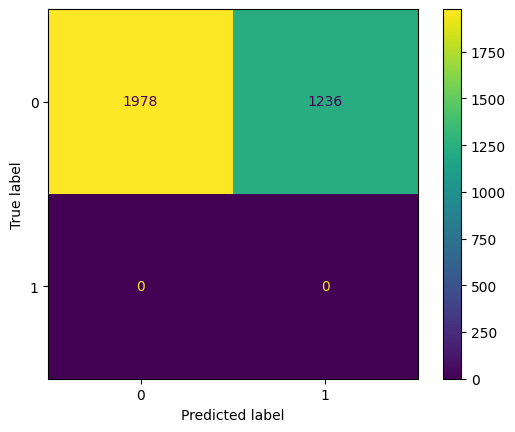


Processing olid dataset...


100%|██████████| 13170/13170 [04:11<00:00, 52.27it/s]


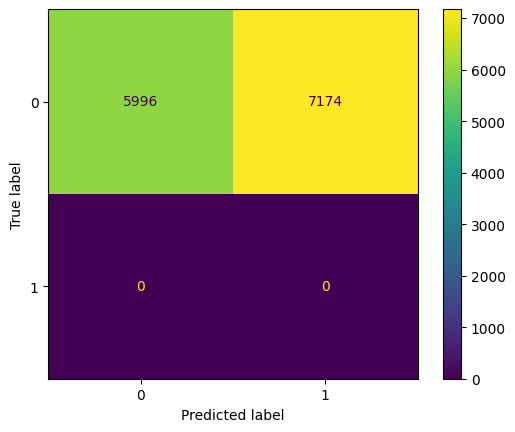


Processing hate_xplain dataset...


100%|██████████| 5935/5935 [02:16<00:00, 43.33it/s]


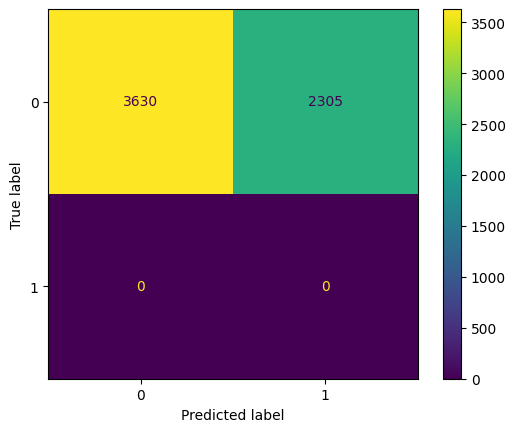


Processing tuke_sk dataset...


100%|██████████| 8625/8625 [03:47<00:00, 37.91it/s]


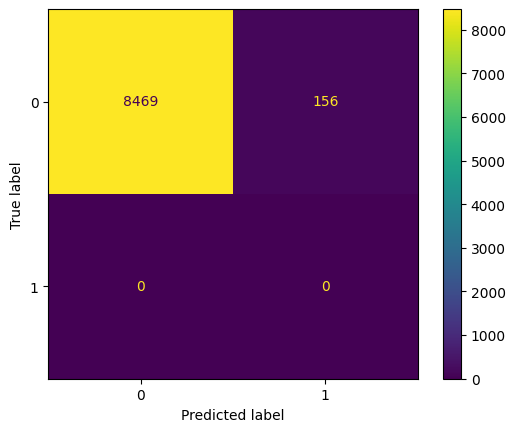


Processing dkk dataset...


100%|██████████| 41/41 [00:01<00:00, 26.60it/s]


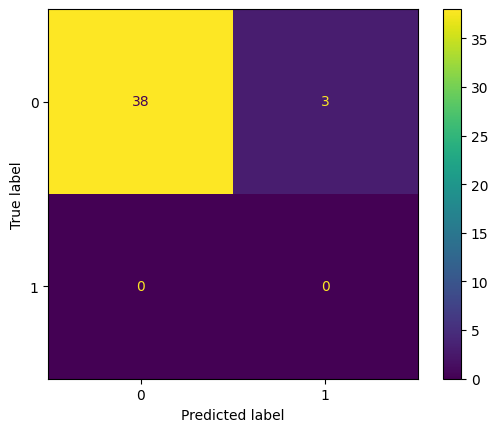


Processing dkk_all dataset...


100%|██████████| 329/329 [00:11<00:00, 27.51it/s]


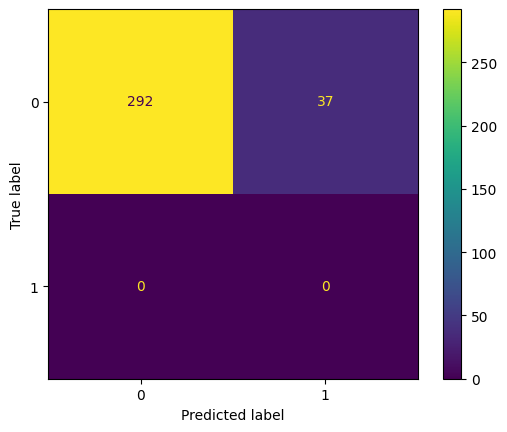

In [6]:
for domain, inference_df in datasets.items():
    print(f"\nProcessing {domain} dataset...")
    predictions_mlp = []
    prediction_times_mlp = []
    actuals_mlp = []

    try:
        for _, row in tqdm(inference_df.iterrows(), total=len(inference_df)):
            # Tokenize input text
            start_time = time.perf_counter_ns()
            inputs = tokenizer_func(row["prompt"])

            # Convert to numpy arrays for ONNX
            onnx_inputs = {
                'input_ids': inputs['input_ids'].numpy(),
                'attention_mask': inputs['attention_mask'].numpy(),
            }

            # Run inference
            pred = mlp_classifier.run(None, onnx_inputs)[0]
            end_time = time.perf_counter_ns()

            prediction_times_mlp.append(end_time - start_time)
            predictions_mlp.append(0 if np.argmax(pred) == 1 else 1)
            actuals_mlp.append(row["label"])

        # Evaluate results
        evaluate_run(
            predictions=predictions_mlp,
            true_labels=actuals_mlp,
            latency=statistics.mean(prediction_times_mlp),
            domain=domain,
            embed_model="MiniLM-L12",
            model_name="MLP-ONNX",
            train_acc=0.0,
            cost=0.0,
            training=False,
        )

    except Exception as e:
        print(f"Error processing {domain} dataset: {e}")
        continue